## Simple Binary Classification with SHAP predictions interpreation

In this notebook we will train a Deep Tabular model and intepret the results using SHAP.
**Focus** of this notebook is not performance or the models themselves, only how to integrate SHAP with trained models from the library.

**DISCLAIMER**

Currently, only standalone deeptabular model is explainable, ie. interpretable by SHAP. SHAP can not use dictionaries as input, only numpy or tensor arrays. Complex models, like models that include wide **AND** deep model component use datasets in the form of dictionaries to separate dataset values for each part of the whole model. The resulting prediction is combined in Trainer.predict() method of the Trainer. SHAP works only with pure pytorch models, ie. use their implicit forward method - model(). After the model training using Trainer we need to extract deeptabular component of the model from the Trainer - ie. trained deeptabular model, and in case of classification objective append sigmoid/softmax layer, as these are included in Trainer.predict() method. For thorough understanding of the code we encourage users to check the trainer.predict() code in the library.

In [1]:
from typing import Tuple, Optional, Union, Literal
import shap
from copy import copy, deepcopy
import numpy as np
import torch
from torch import nn

from pytorch_widedeep.preprocessing import TabPreprocessor
from pytorch_widedeep.training import Trainer
from pytorch_widedeep.models import TabMlp, WideDeep
from pytorch_widedeep import datasets

from sklearn.preprocessing import LabelEncoder
import dill

# Load datasets

**Regression toy dataset**

In [2]:
data_reg = datasets.load_california_housing(as_frame=True)

**Binary toy dataset**

In [3]:
data_binary = datasets.load_adult(as_frame=True)
data_binary["income"] = LabelEncoder().fit_transform(data_binary["income"].values)

**Multiclass toy dataset**

In [4]:
data_multiclass = datasets.load_ecoli(as_frame=True)
# drop low count classes
low_count_classes = data_multiclass["class"].value_counts()
data_multiclass = data_multiclass[data_multiclass["class"].isin(low_count_classes[low_count_classes<6].index.values) == False]
data_multiclass.reset_index(drop=True, inplace=True)
data_multiclass["class"] = LabelEncoder().fit_transform(data_multiclass["class"].values)
# drop identifier as we do not need it in this example
data_multiclass.drop(columns=["SequenceName"], inplace=True)

# Data preparation

### Preparing the data

**Regression toy dataset**

In [5]:
# deeptabular
tab_preprocessor_reg = TabPreprocessor(
    embed_cols=None,
    continuous_cols=[
        "MedInc",
        "HouseAge",
        "AveRooms",
        "AveBedrms",
        "Population",
        "AveOccup",
        "Latitude",
        "Longitude"
    ],
)
X_tab_reg = tab_preprocessor_reg.fit_transform(data_reg)

**Binary toy dataset**

In [6]:
tab_preprocessor_binary = TabPreprocessor(
    embed_cols=[
        "workclass",
        "fnlwgt",
        "education",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "gender",
        "native-country"
    ],
    continuous_cols=[
        "age",
        "educational-num",
        "capital-gain",
        "capital-loss",
        "hours-per-week"
    ],
)
X_tab_binary = tab_preprocessor_binary.fit_transform(data_binary)


**Multiclass toy dataset**

In [7]:

tab_preprocessor_multiclass = TabPreprocessor(
    embed_cols=None,
    continuous_cols=[
        "mcg",
        "gvh",
        "lip",
        "chg",
        "aac",
        "alm1",
        "alm2"
    ],
)
X_tab_multiclass = tab_preprocessor_multiclass.fit_transform(data_multiclass)

**Targets**

In [8]:
target_reg = data_reg["MedHouseVal"].values
target_binary = data_binary["income"].values
target_multiclass = data_multiclass["class"].values

### Define the models

**Regression model**

In [9]:
tab_mlp_reg = TabMlp(
    column_idx=tab_preprocessor_reg.column_idx,
    cat_embed_input=None,
    cat_embed_dropout=0.1,
    continuous_cols=tab_preprocessor_reg.continuous_cols,
    mlp_hidden_dims=[400, 200],
    mlp_dropout=0.5,
    mlp_activation="leaky_relu",
)
wd_model_reg = WideDeep(deeptabular=tab_mlp_reg)

**Binary model**

In [10]:
tab_mlp_binary = TabMlp(
    column_idx=tab_preprocessor_binary.column_idx,
    cat_embed_input=tab_preprocessor_binary.cat_embed_input,
    cat_embed_dropout=0.1,
    continuous_cols=tab_preprocessor_binary.continuous_cols,
    mlp_hidden_dims=[400, 200],
    mlp_dropout=0.5,
    mlp_activation="leaky_relu",
)
wd_model_binary = WideDeep(deeptabular=tab_mlp_binary)

**Multiclass model**

In [11]:

tab_mlp_multiclass = TabMlp(
    column_idx=tab_preprocessor_multiclass.column_idx,
    cat_embed_input=None,
    cat_embed_dropout=0.1,
    continuous_cols=tab_preprocessor_multiclass.continuous_cols,
    mlp_hidden_dims=[400, 200],
    mlp_dropout=0.5,
    mlp_activation="leaky_relu",
)
wd_model_multiclass = WideDeep(deeptabular=tab_mlp_multiclass, pred_dim=len(np.unique(target_multiclass)))

## Train the models

**Regression trainer**

In [12]:
tab_trainer_reg = Trainer(
    model=wd_model_reg,
    objective="regression",
    optimizers=torch.optim.AdamW(wd_model_reg.parameters(), lr=0.001),
)
tab_trainer_reg.fit(X_tab=X_tab_reg, target=target_reg, n_epochs=4, batch_size=128, val_split=0.2)

valid: 100%|██████████| 33/33 [00:00<00:00, 80.03it/s, loss=0.713]


**Binary trainer**

In [13]:
tab_trainer_binary = Trainer(
    model=wd_model_binary,
    objective="binary",
    optimizers=torch.optim.AdamW(wd_model_binary.parameters(), lr=0.001),
)
tab_trainer_binary.fit(X_tab=X_tab_binary, target=target_binary, n_epochs=4, batch_size=128, val_split=0.2)

valid: 100%|██████████| 77/77 [00:02<00:00, 37.67it/s, loss=0.355]


**Multiclass trainer**

In [14]:
tab_trainer_multiclass = Trainer(
    model=wd_model_multiclass,
    objective="multiclass",
    optimizers=torch.optim.AdamW(wd_model_multiclass.parameters(), lr=0.001),
)
tab_trainer_multiclass.fit(X_tab=X_tab_multiclass, target=target_multiclass, n_epochs=4, batch_size=128, val_split=0.2)

valid: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s, loss=0.91]


In [2]:
#dill.dump_session("cur_session.pkl")

# and to load the session again:
dill.load_session("cur_session.pkl")

# SHAP - predictions explanations
Force and decision plots serve same purpose, but force plots require javascript for rendering and can't handle multioutput models, eg. multiclass classificaiton models. Therefore we focus on decision and not force plots.

In [19]:
import shap
from torch.nn import Module

class Sigmoid2d(Module):
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        out = torch.sigmoid(input)
        return torch.cat((1-out,out), dim=1)


class ShapExplainer(object):
    def __init__(
        self,
    ):
        super(ShapExplainer, self).__init__()
    
    def fit(self, tab_trainer: Trainer, X_tab_train: np.ndarray, explainer_type: Literal["kernel", "deep"]):
        """Fit SHAP explainer.

        Args:
            tab_trainer (np.ndarray): deep tabular model component input data
            X_tab_train (Trainer): pytorch widedeep model trainer
            explainer_type (str): type of SHAP explainer
        Returns:
            self.model (): model in a form integratable with SHAP explainer
            self.explainer (): fitted SHAP explainer
        """
        self.explainer_type = explainer_type
        self.objective = copy(tab_trainer.objective)

        if self.explainer_type == "kernel":
            self.model = deepcopy(tab_trainer)
            self.explainer = shap.KernelExplainer(model=self._kernel_explain_model_predict, data=X_tab_train[np.random.choice(X_tab_train.shape[0], size=50, replace=False)])
        elif self.explainer_type == "deep":
            self.model = self._deep_explain_data_model(tab_trainer)
            self.explainer = shap.DeepExplainer(model=self.model, data=torch.tensor(X_tab_train[np.random.choice(X_tab_train.shape[0], size=50, replace=False)]))

    def _labels(self, predictions):
        if self.objective == "regression":
            labels = [f"Sample {i} ({predictions[i].round(2):.2f})" for i in range(len(predictions))]
        elif self.objective in ["binary", "multiclass"]:
            labels = [f"Class {i} ({predictions[i].round(2):.2f})" for i in range(len(predictions))]
        return labels

    def compute_shap_values(self, X_tab_explain: np.ndarray) -> Union[np.ndarray, torch.Tensor]:
        """Helper method to compute SHAP values for other shap plots not included in the ShapExplainer object.

        Args:
            X_tab_explain (np.ndarray): array of values to explain
        Returns:
            shap_values (np.ndarray): computed shap values
        """
        if self.explainer_type == "kernel":
            shap_values = self.explainer.shap_values(X_tab_explain)
        elif self.explainer_type == "deep":
            X_tab_explain_tensor = torch.tensor(X_tab_explain)
            shap_values = self.explainer.shap_values(X_tab_explain_tensor)
        return shap_values

    def compute_preds(self, X_tab_explain: np.ndarray) -> Union[np.ndarray, torch.Tensor]:
        """Helper method to compute SHAP values for other shap plots not included in the ShapExplainer object.

        Args:
            X_tab_explain (np.ndarray): array of values to explain
        Returns:
            preds (np.ndarray): computed shap values
        """
        if self.explainer_type == "kernel":
            preds = self._kernel_explain_model_predict(data=X_tab_explain)
        elif self.explainer_type == "deep":
            X_tab_explain_tensor = torch.tensor(X_tab_explain)
            preds = self.model(X_tab_explain_tensor).detach().numpy()

        if self.objective in ["binary", "multiclass"]:
        # classification predictions produce arrays of arrays
            preds = np.squeeze(preds)
        elif self.objective == "regression" and self.explainer_type == "deep":
            preds = np.squeeze(preds, axis=1)
        return preds

    def explain_decision_plot(self, X_tab_explain: np.ndarray, feature_names: Optional[list]=None):
        """Process the data and pick proper decision plot based on model output and SHAP explainer type.

        Args:
            X_tab_explain (np.ndarray): deep tabular model component input data
        Returns:
            shap_decision_plot (): decision plot
        """
        if (self.objective in ["binary", "multiclass"]) and (len(X_tab_explain.shape) > 1):
            raise ValueError("Multioutput decision plots for classification support only per value analysis.")
        elif len(X_tab_explain.shape) == 1:
            X_tab_explain = np.expand_dims(X_tab_explain, 0)

        predictions = self.compute_preds(X_tab_explain)
    
        if self.objective == "regression":
            shap_values = self.compute_shap_values(X_tab_explain)
            shap_decision_plot = shap.decision_plot(
                base_value=self.explainer.expected_value,
                shap_values=shap_values,
                features=X_tab_explain,
                feature_names=feature_names,
                legend_labels=self._labels(predictions),
                )
        elif self.objective in ["binary", "multiclass"]:
            shap_values = self.compute_shap_values(X_tab_explain)
            shap_decision_plot = shap.multioutput_decision_plot(
                base_values=self.explainer.expected_value.tolist(),
                shap_values=shap_values,
                features=X_tab_explain, 
                feature_names=feature_names,
                legend_labels=self._labels(predictions),
                row_index=0,
                )
        return shap_decision_plot

    def _kernel_explain_model_predict(self, data: np.ndarray) -> np.ndarray:
        """Function to predict values inrepreted by Kernel Explainer

        Args:
            data (np.ndarray): deep tabular model component input data
        Returns:
            predictions (np.ndarray): predictions
        """
        if self.objective == "regression":
            predictions = self.model.predict(X_tab=data)
        elif self.objective in ["binary", "multiclass"]:
            predictions = self.model.predict_proba(X_tab=data)
        return predictions
    
    @staticmethod
    def _deep_explain_data_model(tab_trainer: Trainer) -> torch.nn.Sequential:
        """Simple function to extract the deeptabular component of the model for explanation using Deep Explainer

        Args:
            tab_trainer (Trainer): fitted model Trainer
        Returns:
            explain_model (torch.nn.Sequential): deep tabular component model of the fitted trainer
        """
        tab_trainer_dpc = deepcopy(tab_trainer)
        if tab_trainer_dpc.objective == "regression":
            explain_model = tab_trainer_dpc.model.deeptabular
        if tab_trainer_dpc.objective == "binary":
            explain_model = nn.Sequential(
                tab_trainer_dpc.model.deeptabular,
                Sigmoid2d()
                #nn.Sigmoid()
            )
        if tab_trainer_dpc.objective == "multiclass":
            explain_model = nn.Sequential(
                tab_trainer_dpc.model.deeptabular,
                nn.Softmax(dim=1)
            )
        return explain_model

## Kernel Explainer
Kernel explainer expects prediction function and numpy ndarray input type. Kernel explainer also uses notion of random background samples that are used for the explanation of the predictions.

As random background samples we simply use samples 5:55 and explain first 5 samples for explanation. In real use case we encourage users to train/valid/test split data and use validation dataset as background samples.

For more information about Kernel Eplainer please read SHAP documentation or related [paper](https://papers.nips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf).

**Regression model explainer**

predict: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

predict: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
p

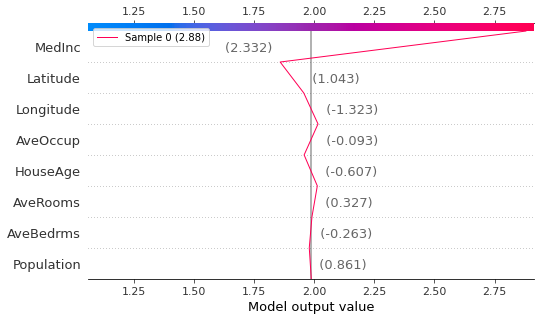

In [21]:
reg_explainer = ShapExplainer()
reg_explainer.fit(tab_trainer=tab_trainer_reg, X_tab_train=X_tab_reg, explainer_type="kernel")
reg_explainer.explain_decision_plot(X_tab_explain=X_tab_reg[1], feature_names=list(tab_preprocessor_reg.column_idx))

**Binary model explainer**

predict: 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

predict: 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
p

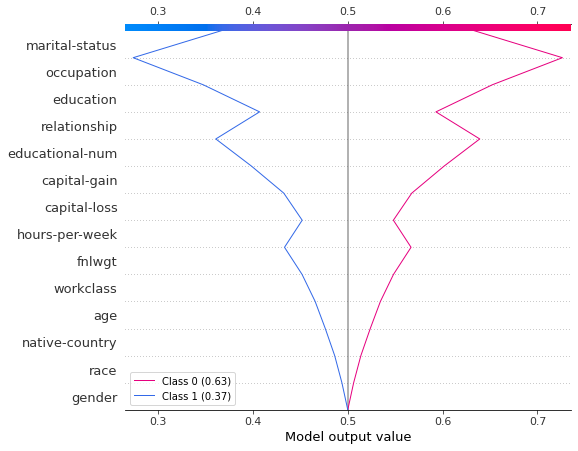

In [16]:
binary_explainer = ShapExplainer()
binary_explainer.fit(tab_trainer=tab_trainer_binary, X_tab_train=X_tab_binary, explainer_type="kernel")
binary_explainer.explain_decision_plot(X_tab_explain=X_tab_binary[1], feature_names=list(tab_preprocessor_binary.column_idx))

**Multiclass model explainer**

predict: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

predict: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
p

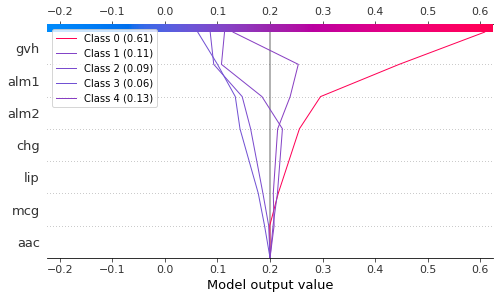

In [15]:
multiclass_explainer = ShapExplainer()
multiclass_explainer.fit(tab_trainer=tab_trainer_multiclass, X_tab_train=X_tab_multiclass, explainer_type="kernel")
multiclass_explainer.explain_decision_plot(X_tab_explain=X_tab_multiclass[0], feature_names=list(tab_preprocessor_multiclass.column_idx))

## Deep Explainer (DeepLift + LIME)

Deep explainer expects model(Keras, Tensorflow or PyTorch) and Tensor input type. Deep explainer also uses notion of random background samples that are used for the explanation of the predictions.

As random background samples we simply use samples 5:1000 and explain first 5 samples for explanation. In real use case we encourage users to train/valid/test split data and use validation dataset as background samples.

For more information about Kernel Eplainer please read SHAP documentation or related [paper](https://papers.nips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf).

**Regression model explainer**

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


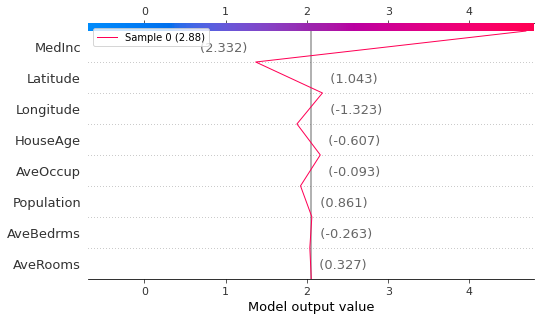

In [14]:
reg_explainer = ShapExplainer()
reg_explainer.fit(tab_trainer=tab_trainer_reg, X_tab_train=X_tab_reg, explainer_type="deep")
reg_explainer.explain_decision_plot(X_tab_explain=X_tab_reg[1], feature_names=list(tab_preprocessor_reg.column_idx))

**Binary model explainer**

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


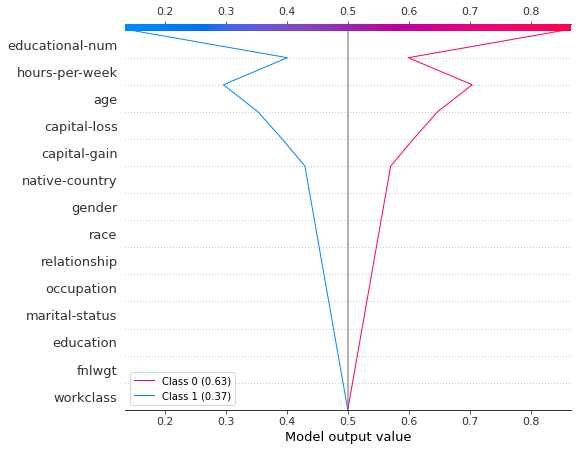

In [5]:
binary_explainer = ShapExplainer()
binary_explainer.fit(tab_trainer=tab_trainer_binary, X_tab_train=X_tab_binary, explainer_type="deep")
binary_explainer.explain_decision_plot(X_tab_explain=X_tab_binary[1], feature_names=list(tab_preprocessor_binary.column_idx))

**Multiclass model explainer**

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


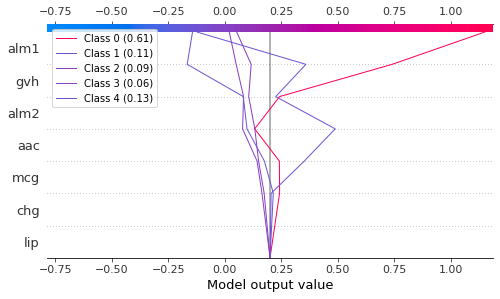

In [6]:
multiclass_explainer = ShapExplainer()
multiclass_explainer.fit(tab_trainer=tab_trainer_multiclass, X_tab_train=X_tab_multiclass, explainer_type="deep")
multiclass_explainer.explain_decision_plot(X_tab_explain=X_tab_multiclass[0], feature_names=list(tab_preprocessor_multiclass.column_idx))